# 01.01 - PROYECTO KAGGLE

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink() #inicializar

replicating local resources


## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [ ]:
!pip install -q kaggle #instalar el paquete de kaggle en el entorno
from google.colab import files #importar libreria para subir archivo .json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elianaarroyave","key":"fc00726b4e73cd3cd95db3316640b824"}'}

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.' # lectura de credenciales
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 84% 17.0M/20.1M [00:00<00:00, 34.0MB/s]
100% 20.1M/20.1M [00:00<00:00, 38.1MB/s]


## unzip and inspect data

In [ ]:
!unzip udea*.zip > /dev/null #descomprimir archivos

In [ ]:
!wc *.csv #visualizar cantidad de datos

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


## load `train.csv` data with pandas



In [ ]:
import pandas as pd #importar librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import local.lib.timeseries as ts
from local.lib import calhousing as ch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from scipy import stats
from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets, svm
import warnings
warnings.filterwarnings("ignore")
from local.lib import mlutils

z = pd.read_csv("train.csv") #leer el archivo .csv
print ("shape of loaded dataframe", z.shape) #leer filas y columnas


shape of loaded dataframe (692500, 12)


In [ ]:
z.head() #mostrar data frame

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,RENDIMIENTO_GLOBAL
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Postgrado,No,medio-alto
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Técnica o tecnológica incompleta,No,bajo
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No,bajo
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Secundaria (Bachillerato) completa,No,alto
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Primaria completa,No,medio-bajo


## we will do a model using only two columns

- we have to predict column `RENDIMIENTO_GLOBAL` using the rest

- we will use columns
  - `FAMI_TIENEINTERNET` which we will need to convert to a **onehot encoding**
  - `ESTU_HORASSEMANATRABAJA` which we will need to convert to a **continuous encoding**

In [ ]:
data_train=z.copy() #creamos una copia para no alterar el dataframe original
data_train = data_train[['ESTU_HORASSEMANATRABAJA', 'FAMI_TIENEINTERNET', 'RENDIMIENTO_GLOBAL']]
data_train.head()

,ESTU_HORASSEMANATRABAJA,FAMI_TIENEINTERNET,RENDIMIENTO_GLOBAL
0,Menos de 10 horas,Si,medio-alto
1,0,No,bajo
2,Más de 30 horas,Si,bajo
3,0,Si,alto
4,Entre 21 y 30 horas,Si,medio-bajo


<Axes: xlabel='ESTU_HORASSEMANATRABAJA'>

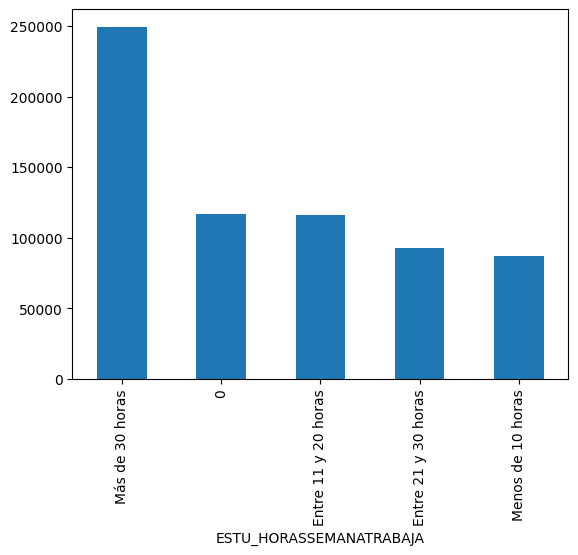

In [ ]:
data_train.ESTU_HORASSEMANATRABAJA.value_counts().plot(kind='bar')

<Axes: xlabel='FAMI_TIENEINTERNET'>

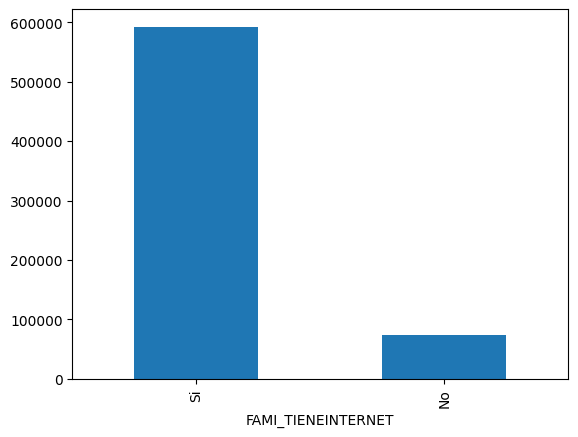

In [ ]:
data_train.FAMI_TIENEINTERNET.value_counts().plot(kind='bar')

## Inspect visually if these two columns have distinctive behaviour with respect to what we want to predict

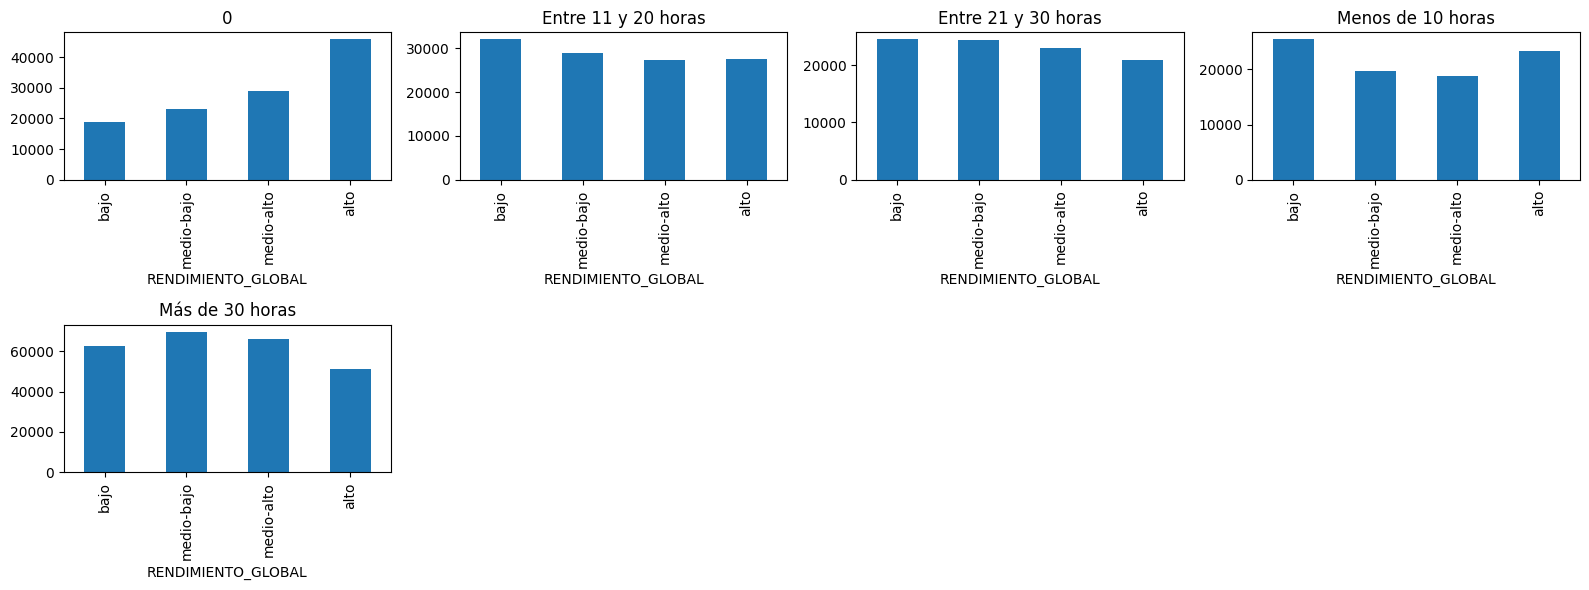

In [ ]:
from rlxutils import subplots
import matplotlib.pyplot as plt

c = sorted(data_train.ESTU_HORASSEMANATRABAJA.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = data_train[data_train.ESTU_HORASSEMANATRABAJA==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

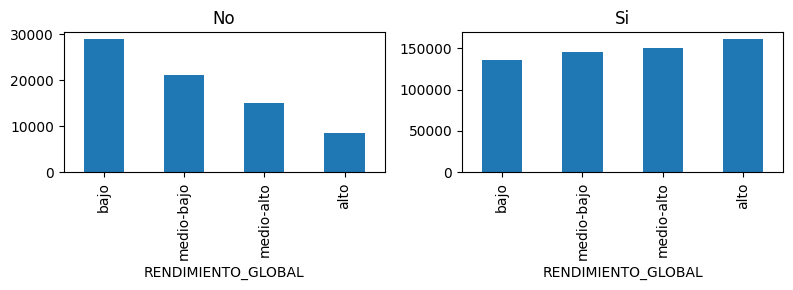

In [ ]:
c = sorted(data_train.FAMI_TIENEINTERNET.value_counts().index)
for ax,ci in subplots(c, n_cols=4, usizex=4):
    zc = data_train[data_train.FAMI_TIENEINTERNET==ci]
    zc.RENDIMIENTO_GLOBAL.value_counts()[['bajo', 'medio-bajo', 'medio-alto', 'alto']].plot(kind='bar')
    plt.title(ci)

## We see the distribution of each column

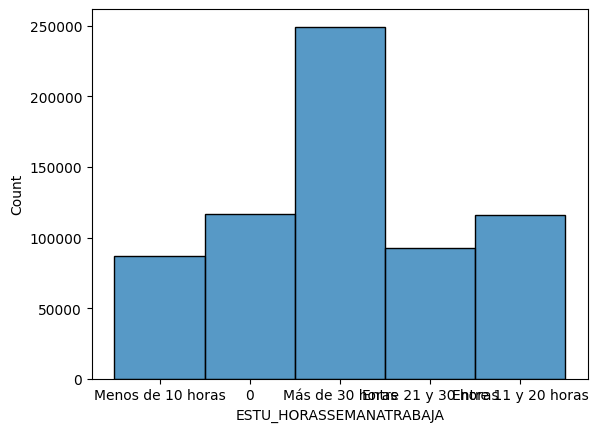

In [ ]:
sns.histplot(data_train['ESTU_HORASSEMANATRABAJA']); # variacion ESTU_HORASSEMANATRABAJA

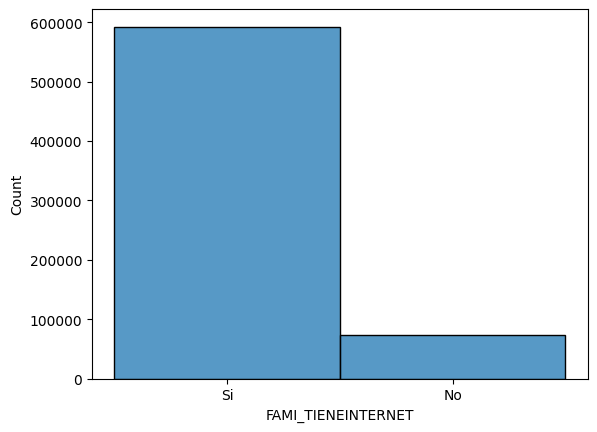

In [ ]:
sns.histplot(data_train['FAMI_TIENEINTERNET']); # variacion de FAMI_TIENEINTERNET

## Basic cleanup

considering that we have in total 692K data items, Let's look at the missing values ​​in each column

In [ ]:
sum(data_train.ESTU_HORASSEMANATRABAJA.isna()), sum(data_train.FAMI_TIENEINTERNET.isna())

(30857, 26629)

we will substitute `nan` values with a preset symbol to mark them

In [ ]:
data_train.ESTU_HORASSEMANATRABAJA.values[data_train.ESTU_HORASSEMANATRABAJA.isna()] = 'no info'
data_train.FAMI_TIENEINTERNET.values[data_train.FAMI_TIENEINTERNET.isna()] = 'no info'
sum(data_train.ESTU_HORASSEMANATRABAJA.isna()), sum(data_train.FAMI_TIENEINTERNET.isna())

(0, 0)

### Cleaning `ESTU_HORASSEMANATRABAJA`

we convert `ESTU_HORASSEMANATRABAJA` to a **continuous** value since the ordering makes sense and we would like models to have a chance to capture it.

observe we assign `no info` to 0, which is somewhat artificial in this case

In [ ]:
cmap = {
    '0': 0,
    'Entre 11 y 20 horas': 15,
    'Entre 21 y 30 horas': 25,
    'Menos de 10 horas': 5,
    'Más de 30 horas': 35,
    'no info': 15 #promedio de los valores
}

# Mapear los valores de la columna usando el diccionario cmap
data_train['ESTU_HORASSEMANATRABAJA'] = data_train['ESTU_HORASSEMANATRABAJA'].map(cmap)

In [ ]:
df_train = (data_train)
df_train

,ESTU_HORASSEMANATRABAJA,FAMI_TIENEINTERNET,RENDIMIENTO_GLOBAL
0,5,Si,medio-alto
1,0,No,bajo
2,35,Si,bajo
3,0,Si,alto
4,25,Si,medio-bajo
...,...,...,...
692495,15,Si,medio-alto
692496,35,Si,bajo
692497,5,Si,medio-bajo
692498,5,No,bajo


### Cleaning `FAMI_TIENEINTERNET`

observe that for `FAMI_TIENEINTERNET` there could be many choices on how to deal with missing data

- leave it as it is
- unite `no info`, `No sabe` , `No Aplica` into a single symbol
- etc.


In [ ]:
z.FAMI_TIENEINTERNET = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in z.FAMI_TIENEINTERNET.values]

In [ ]:
data_train.FAMI_TIENEINTERNET.value_counts()

,count
FAMI_TIENEINTERNET,
Si,592514
No,73357
no info,26629


first we create the onehot mapping

In [ ]:
# Extraer los valores de la columna
x = data_train.FAMI_TIENEINTERNET.values
# Obtener los valores únicos y ordenarlos
FAMI_TIENEINTERNET_vals = sorted(np.unique(x))
# Crear el diccionario de codificación One-Hot
FAMI_TIENEINTERNET_onehot_vals = {val: np.eye(len(FAMI_TIENEINTERNET_vals))[i] for i,val in enumerate(FAMI_TIENEINTERNET_vals)}
## Mostrar el diccionario resultante
FAMI_TIENEINTERNET_onehot_vals

{'No': array([1., 0., 0.]),
 'Si': array([0., 1., 0.]),
 'no info': array([0., 0., 1.])}

In [ ]:
FAMI_TIENEINTERNET_onehot_enc = np.r_[[FAMI_TIENEINTERNET_onehot_vals[i] for i in data_train.FAMI_TIENEINTERNET]] #crear arreglo numpy
FAMI_TIENEINTERNET_onehot_enc

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [ ]:
FAMI_TIENEINTERNET_df = pd.DataFrame(FAMI_TIENEINTERNET_onehot_enc, columns=[f"FAMI_TIENEINTERNET__{v}" for v in FAMI_TIENEINTERNET_onehot_vals])
FAMI_TIENEINTERNET_df #mostrar nuevo dataframe

,FAMI_TIENEINTERNET__No,FAMI_TIENEINTERNET__Si,FAMI_TIENEINTERNET__no info
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
692495,0.0,1.0,0.0
692496,0.0,1.0,0.0
692497,0.0,1.0,0.0
692498,1.0,0.0,0.0


and we assemble everything into a single dataframe, removing the original `FAMI_TIENEINTERNET` column.


In [ ]:
data_train = pd.concat([FAMI_TIENEINTERNET_df, data_train], axis=1).drop('FAMI_TIENEINTERNET', axis=1)
data_train.shape

(692500, 5)

In [ ]:
data_train.head()

,FAMI_TIENEINTERNET__No,FAMI_TIENEINTERNET__Si,FAMI_TIENEINTERNET__no info,ESTU_HORASSEMANATRABAJA,RENDIMIENTO_GLOBAL
0,0.0,1.0,0.0,5,medio-alto
1,1.0,0.0,0.0,0,bajo
2,0.0,1.0,0.0,35,bajo
3,0.0,1.0,0.0,0,alto
4,0.0,1.0,0.0,25,medio-bajo


## convert target (prediction) column into discrete values

now everything in our dataset is **numeric**!!!

In [ ]:
y_col = 'RENDIMIENTO_GLOBAL'

rmap = {'alto': 3, 'bajo':0, 'medio-bajo':1, 'medio-alto':2}
data_train[y_col] = [rmap[i] for i in data_train[y_col]]
data_train.head()

,FAMI_TIENEINTERNET__No,FAMI_TIENEINTERNET__Si,FAMI_TIENEINTERNET__no info,ESTU_HORASSEMANATRABAJA,RENDIMIENTO_GLOBAL
0,0.0,1.0,0.0,5,2
1,1.0,0.0,0.0,0,0
2,0.0,1.0,0.0,35,0
3,0.0,1.0,0.0,0,3
4,0.0,1.0,0.0,25,1


## build `X` and `y` for training a model

observe we sort columns to make sure we always get the same ordering

In [ ]:
data_train = data_train[sorted(data_train.columns)] # Obtener los valores únicos y ordenarlos

X = data_train[[c for c in data_train.columns if c!=y_col]].values
y = data_train[y_col].values
X.shape, y.shape

((692500, 4), (692500,))

## split into train and test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xtr, Xts, ytr, yts = train_test_split(X,y, train_size=0.8)
Xtr.shape, Xts.shape, ytr.shape, yts.shape

((554000, 4), (138500, 4), (554000,), (138500,))

## Make a linear model random forest for classification

train model

In [ ]:
#Se plantea un modelo lineal y se comprueba el score alcanzado
modelo_l = LinearRegression()
modelo_l.fit(Xtr, ytr)

print("Score train: "+ str(modelo_l.score(Xtr, ytr)))
print("Score test: "+ str(modelo_l.score(Xts, yts)))

Score train: 0.032444658499196755
Score test: 0.035290448969833466


In [ ]:
#Se calcula el valor absoluto medio y error cuadratico medio
print("Valor absoluto medio: " + str(median_absolute_error(yts, modelo_l.predict(Xts))))
print("Error cuadratico medio: " + str(mean_squared_error(yts, modelo_l.predict(Xts))))

Valor absoluto medio: 0.9212102378705831
Error cuadratico medio: 1.2089507602644745


In [ ]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

In [ ]:
rel_mrae(modelo_l, Xtr, ytr), rel_mrae(modelo_l, Xts, yts)

<ipython-input-32-ac7ae08d3e95>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(preds-y)/y)
<ipython-input-32-ac7ae08d3e95>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs(preds-y)/y)


(inf, inf)

In [ ]:
preds = modelo_l.predict(Xts)
errors = np.abs(preds-yts)/yts

<ipython-input-34-48920ab09c45>:2: RuntimeWarning: divide by zero encountered in divide
  errors = np.abs(preds-yts)/yts


In [ ]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size):
  trscores, tsscores = [], []
  for _ in range(10):
    Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=test_size)
    estimator.fit(Xtr, ytr)
    trscores.append(rel_mrae(estimator, Xtr, ytr))
    tsscores.append(rel_mrae(estimator, Xts, ytr))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [ ]:
from sklearn.model_selection import ShuffleSplit, KFold,cross_val_score
ss = ShuffleSplit(n_splits=3, test_size=0.3)

for a,b in ss.split(range(10)):
    print (a, b)

[4 0 8 3 5 7 1] [2 9 6]
[2 3 9 5 4 1 0] [8 7 6]
[5 1 7 0 8 4 6] [9 3 2]


In [ ]:
ss = KFold(n_splits=3)

for a,b in ss.split(range(10)):
    print (a, b)

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [ ]:
from sklearn.model_selection import ShuffleSplit

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(Xtr, ytr)
y_preds = dt.predict(X)
print('El Score obtenido: '+str (dt.score(Xtr, ytr)))

El Score obtenido: 0.041733891949178314


In [ ]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(Xtr, ytr)
y_preds = dt.predict(Xtr)
print('El Score obtenido: '+str (dt.score(Xtr, ytr)))

El Score obtenido: 0.042870274704157496


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=2, max_depth=2)
rf.fit(Xtr, ytr)
print (rf.score(Xtr, ytr),rf.score(Xtr, ytr))

0.04173132584514472 0.04173132584514472


In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [ ]:
estimator1 = DecisionTreeRegressor(max_depth=5)
z1 = cross_validate(estimator1, Xtr, ytr, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))

get predictions

In [ ]:
preds_tr = rf.predict(Xtr)
preds_ts = rf.predict(Xts)
preds_tr.shape, preds_ts.shape

((554000,), (138500,))

In [ ]:
preds_ts[:10]

array([1.47987383, 1.94186842, 1.47987383, 1.47987383, 1.94186842,
       1.47987383, 1.47987383, 1.47987383, 1.47987383, 1.00961673])

In [ ]:
yts[:10]

array([1, 3, 1, 3, 1, 0, 2, 0, 3, 0])

In [ ]:
print (preds_tr[:10])
print (preds_ts[:10])

[1.47987383 1.47987383 1.47987383 1.94186842 1.47987383 1.94186842
 1.47987383 1.94186842 1.94186842 1.47987383]
[1.47987383 1.94186842 1.47987383 1.47987383 1.94186842 1.47987383
 1.47987383 1.47987383 1.47987383 1.00961673]


get accuracy and confusion matrices

In [ ]:
np.mean(preds_tr==ytr), np.mean(preds_ts==yts)

(0.0, 0.0)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm_tr = confusion_matrix(ytr, preds_tr)
cm_ts = confusion_matrix(yts, preds_ts)

# normalizar
cm_tr = cm_tr / cm_tr.sum(axis=1).reshape(-1,1)
cm_ts = cm_ts / cm_ts.sum(axis=1).reshape(-1,1)

observe how each row in the confusion matrix adds up to 1.

In [ ]:
import seaborn as sns #ver la tendencia de la diagonal en la matriz
for ax,i in subplots(2, usizex=4):
  if i==0: sns.heatmap(cm_tr, annot=True); plt.title("confusion matrix train")
  if i==1: sns.heatmap(cm_ts, annot=True); plt.title("confusion matrix test")
  plt.ylabel("true")
  plt.xlabel("predicted")

## We keep the first model, now we apply the same procedure to `test.csv`

observe:
- there is no `RENDIMIENTO_GLOBAL` column
- we must keep the IDs so that we can create properly the submission file

In [ ]:
zt = pd.read_csv("test.csv") #leer el archivo de testeo
zt

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No
...,...,...,...,...,...,...,...,...,...,...,...,...
296781,296781,496981,20195,ADMINISTRACION DE EMPRESAS,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 1,Si,Primaria incompleta,Primaria incompleta,Si
296782,296782,209415,20183,DERECHO,META,Entre 1 millón y menos de 2.5 millones,0,Estrato 4,Si,Educación profesional completa,Educación profesional completa,No
296783,296783,239074,20212,DERECHO,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Educación profesional completa,No
296784,296784,963852,20195,INGENIERIA AERONAUTICA,ANTIOQUIA,Entre 5.5 millones y menos de 7 millones,Entre 11 y 20 horas,Estrato 3,Si,Educación profesional completa,Educación profesional completa,No


In [ ]:
zt_ids = zt['ID'].values #seleccionar columnas
zt = zt[['FAMI_TIENEINTERNET', 'ESTU_HORASSEMANATRABAJA']]
print ("shape of loaded dataframe", zt.shape)
zt.head()

shape of loaded dataframe (296786, 2)


,FAMI_TIENEINTERNET,ESTU_HORASSEMANATRABAJA
0,Si,Menos de 10 horas
1,Si,Entre 21 y 30 horas
2,Si,0
3,No,Entre 21 y 30 horas
4,Si,Entre 11 y 20 horas


In [ ]:
zt.FAMI_TIENEINTERNET.values[zt.FAMI_TIENEINTERNET.isna()] = 'no info' #reemplazar valores faltantes por "no info"
zt.ESTU_HORASSEMANATRABAJA.values[zt.ESTU_HORASSEMANATRABAJA.isna()] = 'no info'


In [ ]:
zt = zt.copy()
zt.ESTU_HORASSEMANATRABAJA = np.r_[[cmap[i] for i in zt.ESTU_HORASSEMANATRABAJA]]


In [ ]:
zt.FAMI_TIENEINTERNET = ['no info' if i in ['No sabe', 'No Aplica'] else i for i in zt.FAMI_TIENEINTERNET.values]
FAMI_TIENEINTERNET_onehot_enc = np.r_[[FAMI_TIENEINTERNET_onehot_vals[i] for i in zt.FAMI_TIENEINTERNET]]
FAMI_TIENEINTERNET_df = pd.DataFrame(FAMI_TIENEINTERNET_onehot_enc, columns=[f"FAMI_TIENEINTERNET__{v}" for v in FAMI_TIENEINTERNET_onehot_vals])#crear nuevo dataframe
zt = pd.concat([FAMI_TIENEINTERNET_df, zt], axis=1).drop('FAMI_TIENEINTERNET', axis=1)
zt.shape

(296786, 4)

In [ ]:
zt

,FAMI_TIENEINTERNET__No,FAMI_TIENEINTERNET__Si,FAMI_TIENEINTERNET__no info,ESTU_HORASSEMANATRABAJA
0,0.0,1.0,0.0,5
1,0.0,1.0,0.0,25
2,0.0,1.0,0.0,0
3,1.0,0.0,0.0,25
4,0.0,1.0,0.0,15
...,...,...,...,...
296781,0.0,1.0,0.0,35
296782,0.0,1.0,0.0,0
296783,0.0,1.0,0.0,35
296784,0.0,1.0,0.0,15


create `X` array and predict

In [ ]:
X_test_data = zt[sorted(zt.columns)].values # Obtener los valores únicos y ordenarlos
X_test_data.shape

(296786, 4)

In [ ]:
preds_test_data = lr.predict(X_test_data)

## prepare submission

first, map back the predictions to textual values

In [ ]:
# invertir el mapeo
rmapi = {v:k for k,v in rmap.items()}
text_preds_test_data = [rmapi[i] for i in preds_test_data]


In [ ]:
# crear nuevo data frame

submission = pd.DataFrame([zt_ids, text_preds_test_data], index=['ID', 'RENDIMIENTO_GLOBAL']).T
submission

,ID,RENDIMIENTO_GLOBAL
0,550236,alto
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,alto
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-bajo
296784,963852,alto


In [ ]:
# Guardar en archivo
submission.to_csv("my_submission.csv", index=False)

In [ ]:
!head my_submission.csv # mostrar datos

ID,RENDIMIENTO_GLOBAL
550236,alto
98545,medio-alto
499179,alto
782980,bajo
785185,alto
58495,medio-bajo
705444,alto
557548,alto
519909,bajo


In [ ]:
submission.shape #ver la forma del archivo

(296786, 2)

## Send your submission to Kaggle

You must **join the competition** first

In [ ]:
!kaggle competitions submit -c udea-ai4eng-20242 -f my_submission.csv -m "raul ramos submission with linear model"

100% 4.12M/4.12M [00:02<00:00, 1.63MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia

## Things you can try

- other models (svm, random forest, gaussian, etc.)
- different parameters in the models (like `gamma` for svm, or `max_depth` for random forests). see the doc of each model in `sklearn`.
- use different preprocessing and cleaning methods for different columns
- create new columns manually, for instance,
    - group `ESTU_PRGM_ACADEMICO` into areas of knowlege (engineering, social sciences, etc.)
    - do some operation between columns (multiply, concatenate, etc.)
- integrate external data as new columns, for instance, economic data from each department in Colombia, for each different year, etc.
